In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Bidirectional, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\SHRAVANI\Desktop\major project\BTC-USD (2).csv", header=0)
df.shape

(3352, 7)

In [3]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X[i:(i + time_steps)]
    Xs.append(v)
    ys.append(y[i + time_steps])

  return np.array(Xs), np.array(ys)

In [4]:
# select open, high, low and volumn columns
X = df[['Open', 'High', 'Low', 'Volume']]
# select close columns
y = df[['Close']]

# normalization (ReLU)
# X_transformer = MinMaxScaler((0,1))
# y_transformer = MinMaxScaler((0,1))

# normalization (Tanh)
X_transformer = MinMaxScaler((-1,1))
X_transformer = X_transformer.fit(X)

y_transformer = MinMaxScaler((-1,1))
y_transformer = y_transformer.fit(y)

training_size=int(len(df)*0.9)
test_size=int(len(df)-training_size)

X_train, X_test, y_train, y_test = X[0:training_size], X[training_size:training_size+test_size], y[0:training_size], y[training_size:training_size+test_size]

# transform datasets
X_train_transform = X_transformer.transform(X_train)
X_test_transform = X_transformer.transform(X_test)

y_train_transform = y_transformer.transform(y_train)
y_test_transform = y_transformer.transform(y_test)


In [5]:
# 15 days
time_steps = 15

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(X_train_transform, y_train_transform, time_steps)
X_test, y_test = create_dataset(X_test_transform, y_test_transform, time_steps)

In [6]:
# define model
model = Sequential()

hidden_neurons_layer = 32
# hidden_neurons_layer = (int(X_train.shape[2]*2/3))+1

neurons_output = 1
dropout=0.2

# 1
model.add(Bidirectional(LSTM(units=hidden_neurons_layer, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=dropout))

# 2
model.add(Bidirectional(LSTM(units=hidden_neurons_layer*2, return_sequences=True, activation='tanh')))
model.add(Dropout(rate=dropout))

# 3
model.add(Bidirectional(LSTM(units=hidden_neurons_layer, return_sequences=False, activation='tanh')))
model.add(Dropout(rate=dropout))

# output Layer
model.add(Dense(units=neurons_output))
# Set activation function (If your problem is a regression problem, you should use a linear activation function)
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=1e-3)
mc = ModelCheckpoint('bidirectional-lstm-bitcoin-prices-best-model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

start = time.time()


history = model.fit(
  X_train,
  y_train,
  epochs=30,
  batch_size=32,
  validation_data=(X_test, y_test),
  use_multiprocessing=True,
  callbacks=[es, mc])
print("Training completed")
print(f'training time: {time.time() - start}')

Epoch 1/30


94/94 [==============================] - ETA: 0s - loss: 0.0291 - mean_squared_error: 0.0291
Epoch 1: val_loss improved from inf to 0.00272, saving model to bidirectional-lstm-bitcoin-prices-best-model.h5
94/94 [==============================] - 25s 66ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 2/30
 3/94 [..............................] - ETA: 2s - loss: 0.0107 - mean_squared_error: 0.0107

C:\Users\SHRAVANI\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/94 [============================>.] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 2: val_loss improved from 0.00272 to 0.00230, saving model to bidirectional-lstm-bitcoin-prices-best-model.h5
94/94 [==============================] - 3s 30ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/30
93/94 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 3: val_loss improved from 0.00230 to 0.00216, saving model to bidirectional-lstm-bitcoin-prices-best-model.h5
94/94 [==============================] - 3s 32ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 4/30
93/94 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 4: val_loss did not improve from 0.00216
94/94 [==============================] - 3s 31ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0029 - v

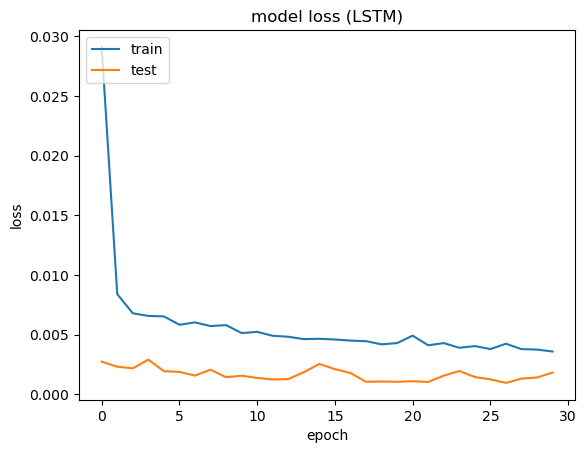

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

11/11 [==============================] - 3s 11ms/step


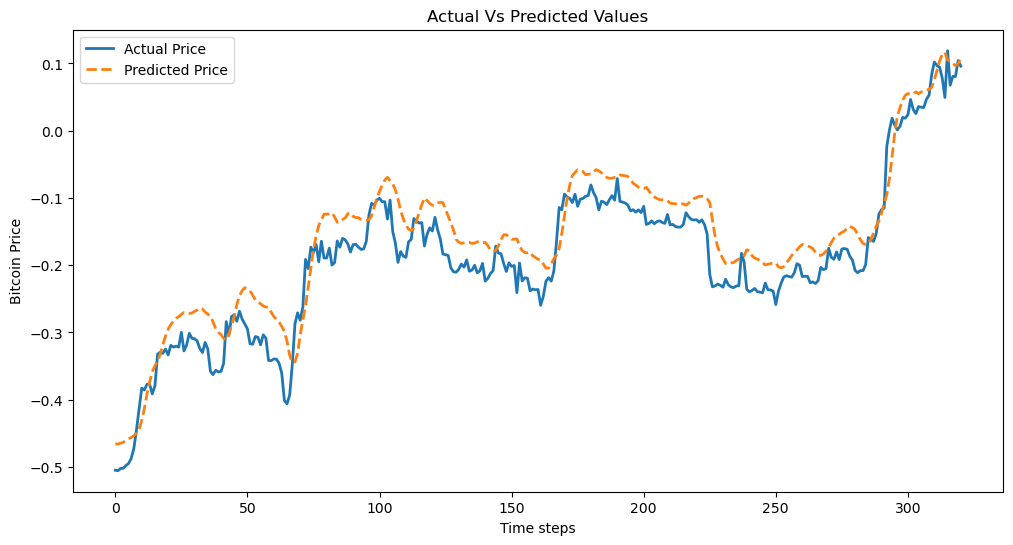

NameError: name 'datacompare' is not defined

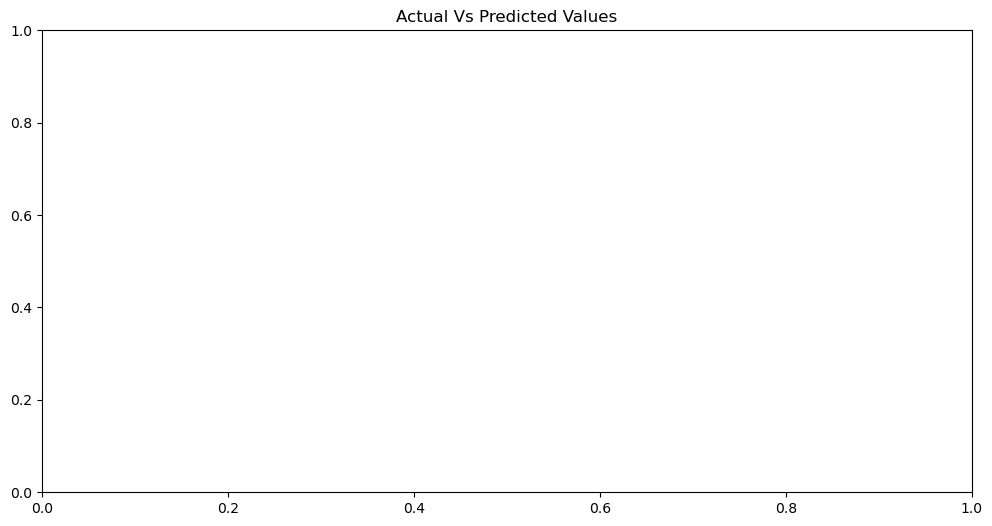

In [9]:
y_hat = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.title('Actual Vs Predicted Values')
plt.plot(y_test, label="Actual Price", linewidth = 2)
plt.plot(y_hat, label="Predicted Price", linestyle='dashed', linewidth = 2)
plt.xlabel('Time steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('bi-lstm.png')
plt.show();


plt.figure(figsize=(12, 6))
plt.title('Actual Vs Predicted Values')
plt.plot(datacompare['Data Test'], label='Actual', linewidth = 2)
plt.plot(datacompare['Prediction Results'],label='Predicted', linestyle = 'dashed', linewidth = 2)
plt.xlabel('Time steps')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('gru.png')
plt.show()

In [ ]:
#rmse = np.sqrt(mean_squared_error(y_test, y_hat))
#print(f'RMSE: {rmse}')

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_hat)
print(f'MAPE: {mape}%')

MAPE: 57.63026747049944%
